# FINAL NPZD PROTOTYPE

# NOTE:

actually assemble all variables involved with a flux, and register from there!
add that extra level of complexity! so the problem if one has a dim and another doesn't

here list of vars supplied and flux routing could happen!!!

do this!

also,
think again how to use groups in the cleanest way possible!




In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.components.variables import SV, SVArray

In [3]:
from phydra.components.fluxes import (LinearForcingInput,
                                      LinearMortality,
                                      MonodGrowth)
from phydra.components.forcings import ConstantForcing, GlobalSlabClimatologyForcing

In [4]:
import numpy as np

In [14]:
@phydra.comp(init_stage=4)
class GroupedFlux:
    """ Somehow i need to get other fluxes here as input args 
            
            the normal xs.group way doesn't really work anymore
            i need to create a dict of labels, that the values of are retrieved from model STATE
            
            -
    """
    
    var = phydra.variable(foreign=True, flux='growth')
    
    @phydra.flux(group_to_arg='X_growth', description='HELLO')
    def growth(self, var, X_growth):
        return sum(X_growth)
    
    
@phydra.comp(init_stage=2)
class SubFlux:
    
    var = phydra.variable(foreign=True)
    
    @phydra.flux(group='X_growth')
    def one_growth(self, var):
        print(var)
        return 0.1 
    
    @phydra.flux(group='X_growth')
    def two_growth(self, var):
        return 0.1

In [15]:
GroupedFlux

phydra.backend.component.GroupedFlux

In [16]:
NPZD = phydra.create({'Nutrient':SV,
                      'Phytoplankton':SV,

                      'Input':LinearForcingInput, 
                      'Growth': MonodGrowth,
                      'Mortality': LinearMortality,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':GlobalSlabClimatologyForcing,
                      'N0x':ConstantForcing,
                      
                      'GroupFlux':GroupedFlux,
                      'SubFlux':SubFlux,
                     })

In [17]:
NPZD

<xsimlab.Model (12 processes, 25 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
Phytoplankton
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
SubFlux
    var               [in] label reference / 
N0
    forcing_label     [in] label / 
    dataset           [in] Options: 'n0x', 'mld', 'tmld', 'par'
    lon               [in] constant value of forcing
    rbb               [in] constant value of forcing
    smooth            [in] smoothing conditions, larger values = st...
    k                 [in] The degree of the spline fit
    lat               [in] constant value of forcing
N0x
    forcing_label     [in] label / 
    value             [in] constant value of forcing
Input
    rate              [in] linear rate of cha

In [19]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,10,0.1),
            input_vars={
                'Nutrient':{'var_label':'N', 'var_init':3.},
                'Phytoplankton':{'var_label':'P', 'var_init':0.1},
                
                'Input':{'var':'N', 'rate':0.1, 'forcing':'N0'},
                
                'Growth':{'consumer':'P', 'resource':'N', 'halfsat':1.5},
                
                'Mortality':{'var':'P', 'rate':0.1},
                
                'N0x':{'forcing_label':'N0x', 'value':2.},
                'N0':{'forcing_label':'N0', 'dataset':'n0x',
                      'lat':47, 'lon':-20, 'rbb':2,
                      'smooth':5, 'k':2},
                
                'GroupFlux':{'var':'P'},
                 'SubFlux':{'var':'P'},
            },
            output_vars="ALL"
            )

In [20]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
VAR IN DICT defaultdict(None, {'time': array([0])})
Initializing component Nutrient
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
Initializing component Phytoplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
Initializing component SubFlux
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
VAR IN DICT defaultdict(None, {'time': array([0]), 'N': array([3.]), 'P': array([0.1]), 'Time_time_flux': array([1])})
[0.1]
VAR IN DICT defaultdict(None, {'time': array([0]), 'N': array([3.]), 'P': array([0.1]), 'Time_time_flux': array([1]), 'SubFlux_one_growth': array([0.1])})
Initializing component

In [21]:
odeint_out

<xarray.Dataset>
Dimensions:                    (clock: 2, input_time: 100, time: 100)
Coordinates:
  * clock                      (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type          <U6 'odeint'
    GroupFlux__growth_value    (time) float64 0.2 0.21 0.23 ... 2.13 2.15 2.17
    GroupFlux__var             <U1 'P'
    Growth__consumer           <U1 'P'
    Growth__halfsat            float64 1.5
    Growth__resource           <U1 'N'
    Growth__uptake_value       (time) float64 0.06667 0.07581 ... 0.5548 0.555
    Input__forcing             <U2 'N0'
    Input__input_value         (time) float64 0.509 0.5092 ... 0.5479 0.5482
    Input__rate                float64 0.1
    Input__var                 <U1 'N'
    Mortality__death_value     (time) float64 0.01 0.01134 ... 1.321 1.335
    Mortality__rate            float64 0.1
    Mortality__var             <U1 'P'
    N0__dataset                <U3 'n0x'
    N0__forcing_label          <U2 'N0'
    N0__forcing_value          (time) float64 5.09 5.094 5.099 ... 5.481 5.484
    N0__k                      int64 2
    N0__lat                    int64 47
    N0__lon                    int64 -20
    N0__rbb                    int64 2
    N0__smooth                 int64 5
    N0x__forcing_label         <U3 'N0x'
    N0x__forcing_value         (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    N0x__value                 float64 2.0
    Nutrient__var_init         float64 3.0
    Nutrient__var_label        <U1 'N'
    Nutrient__var_value        (time) float64 3.0 3.043 ... 0.06542 0.06475
    Phytoplankton__var_init    float64 0.1
    Phytoplankton__var_label   <U1 'P'
    Phytoplankton__var_value   (time) float64 0.1 0.1274 0.1586 ... 13.28 13.42
    SubFlux__one_growth_label  <U18 'SubFlux_one_growth'
    SubFlux__one_growth_value  (time) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    SubFlux__two_growth_label  <U18 'SubFlux_two_growth'
    SubFlux__two_growth_value  (time) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    SubFlux__var               <U1 'P'
    Time__time                 (input_time) float64 0.0 0.1 0.2 ... 9.7 9.8 9.9

In [22]:
import matplotlib.pyplot as plt

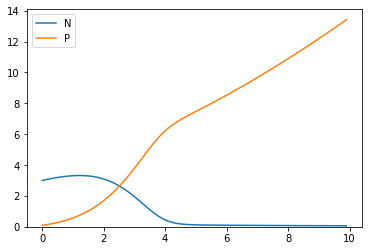

In [23]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

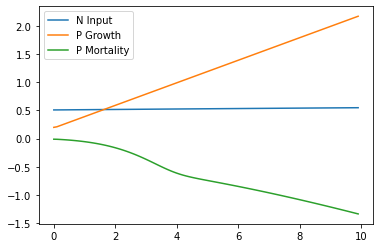

In [24]:
plt.plot(time, odeint_out.Input__input_value, label='N Input')
plt.plot(time, odeint_out.GroupFlux__growth_value, label='P Growth')
plt.plot(time, -odeint_out.Mortality__death_value, label='P Mortality')
plt.legend()

In [18]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

In [19]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component N0x
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
Initializing component N0
Initializing component Input
Initializing component Growth
Initializing component Mortality
Initializing component GroupFlux
assembling model
SOLVER : <phydra.backend.solvers.StepwiseSolver object at 0x164d6a640>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P'] 
Parameters:['N0x_value', 'N0_dataset', 'N0_lat', 'N0_lon', 'N0_rbb', 'N0_smooth', 'N0_k', 'Input_rate', 'Growth_halfsat', 'Mortality_rate'] 
Forcings:['N0x', 'N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Growth_uptake', 'Mortality_death', 'GroupFlux_growth'] 
Full Model Dimensions:[('time', None), ('N', None), ('P', None), ('Time_time_flux', None), ('Input_input', None), ('Growth_uptake', None), ('Mortality_death', None), ('GroupFlux_growth', 

In [20]:
stepwise_out

<xarray.Dataset>
Dimensions:                   (clock: 100, input_time: 100, time: 100)
Coordinates:
  * clock                     (clock) float64 0.0 0.1 0.2 0.3 ... 9.7 9.8 9.9
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type         <U8 'stepwise'
    GroupFlux__growth_value   (time) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    GroupFlux__var            <U1 'P'
    Growth__consumer          <U1 'P'
    Growth__halfsat           float64 1.5
    Growth__resource          <U1 'N'
    Input__forcing            <U2 'N0'
    Input__input_value        (time) float64 0.509 0.5094 ... 0.5481 0.5484
    Input__rate               float64 0.1
    Input__var                <U1 'N'
    Mortality__death_value    (time) float64 0.01 0.01 0.01157 ... 0.581 0.5817
    Mortality__rate           float64 0.1
    Mortality__var            <U1 'P'
    N0__dataset               <U3 'n0x'
    N0__forcing_label         <U2 'N0'
    N0__forcing_value         (time) float64 5.09 5.094 5.099 ... 5.481 5.484
    N0__k                     int64 2
    N0__lat                   int64 47
    N0__lon                   int64 -20
    N0__rbb                   int64 2
    N0__smooth                int64 5
    N0x__forcing_label        <U3 'N0x'
    N0x__value                float64 2.0
    Nutrient__var_init        float64 3.0
    Nutrient__var_label       <U1 'N'
    Nutrient__var_value       (time) float64 3.0 3.044 3.088 ... 0.1564 0.1563
    Phytoplankton__var_init   float64 0.1
    Phytoplankton__var_label  <U1 'P'
    Phytoplankton__var_value  (time) float64 0.1 0.1157 0.1323 ... 5.817 5.823
    Time__time                (input_time) float64 0.0 0.1 0.2 ... 9.7 9.8 9.9

In [21]:
import matplotlib.pyplot as plt

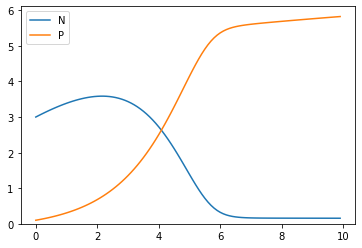

In [22]:
time = stepwise_out.Time__time

plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

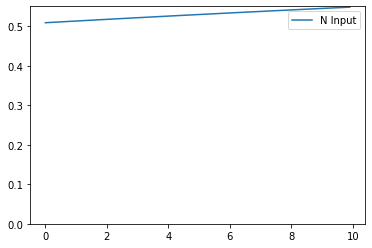

In [23]:
plt.plot(time, stepwise_out.Input__input_value, label='N Input')
plt.ylim(bottom=0)
plt.legend()

In [24]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [25]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
adding variable here:
time
<class 'gekko.gk_variable.GK_SV'>
adding flux
Initializing component Nutrient
adding variable here:
n
<class 'gekko.gk_variable.GK_SV'>
Initializing component Phytoplankton
adding variable here:
p
<class 'gekko.gk_variable.GK_SV'>
Initializing component N0x
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
adding parameter:
n0x_value
Initializing component N0
adding parameter:
adding parameter:
n0_lat
adding parameter:
n0_lon
adding parameter:
n0_rbb
adding parameter:
n0_smooth
adding parameter:
n0_k
Initializing component Input
adding parameter:
input_rate
adding flux
Initializing component Growth
adding parameter:
growth_halfsat
adding flux
Initializing component Mortality
adding parameter:
mortality_rate
adding flux
Initializing component GroupFlux
adding flux
assembling model
SOLVER : <phydra.backend.solvers.GEKKOSolver object at 0x164f46250>
variables time (

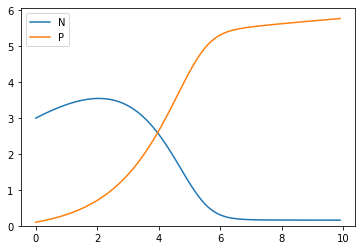

In [26]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

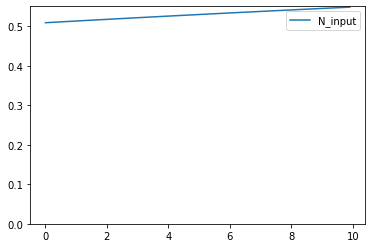

In [27]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.ylim(bottom=0)
plt.legend()